In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/wonminkim/Projects/DATCapstone/data2/data_nasdaq30.csv', index_col=0)
df['Date'] = pd.to_datetime(df['Date'])

# # Forward fill micro, macro, stock
# df[df.columns[1:40]] = df[df.columns[1:40]].ffill()
# # Fill 0 to sentiment
# df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)

df[df.columns[1:-5]] = df.groupby('Ticker')[df.columns[1:-5]].ffill()

# df[df.columns[1:40]] = df.groupby('Ticker')[df.columns[1:40]].ffill()
# df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)
df = df.dropna(subset=df.columns[0:-5])

In [3]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_763,emb_764,emb_765,emb_766,emb_767,Target_1day,Target_1week,Target_1month,Target_1year,Ticker
16,2021-07-08,47.054678,48.062141,46.550948,47.476936,10218000,0.0,0.0,23921.991,5.4,...,1.382723,-1.004278,-0.445223,-0.510819,0.691887,0.534283,0.368992,3.104652,-15.744568,LRCX
19,2021-07-09,47.616380,48.127163,47.230159,48.011219,8372000,0.0,0.0,23921.991,5.4,...,1.382723,-1.004278,-0.445223,-0.510819,0.691887,0.984756,-1.909164,2.750561,-14.400135,LRCX
22,2021-07-12,48.376299,49.297587,48.333211,48.995975,17315000,0.0,0.0,23921.991,5.4,...,1.382723,-1.004278,-0.445223,-0.510819,0.691887,-0.058769,-2.655758,1.181374,-15.365448,LRCX
25,2021-07-13,48.786008,49.041399,48.222738,48.937206,10834000,0.0,0.0,23921.991,5.4,...,1.382723,-1.004278,-0.445223,-0.510819,0.691887,-0.531929,-1.377232,-0.587551,-16.336369,LRCX
28,2021-07-14,49.519286,50.177352,48.285416,48.405277,11507000,0.0,0.0,23921.991,5.4,...,1.382723,-1.004278,-0.445223,-0.510819,0.691887,-0.559349,1.517464,-0.733269,-15.524132,LRCX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24360,2025-01-31,91.530824,94.147412,91.021485,91.121353,20540200,0.0,0.0,29723.864,4.0,...,0.016103,-0.779442,-1.247877,-0.557506,0.750644,NaN,NaN,NaN,NaN,MU
24362,2025-01-31,123.768618,127.838243,119.179044,120.058960,390372900,0.0,0.0,29723.864,4.0,...,0.961005,-0.782348,-0.184249,-0.365352,0.674119,NaN,NaN,NaN,NaN,NVDA
24364,2025-01-31,149.438733,150.360590,148.953037,149.369354,4906700,0.0,0.0,29723.864,4.0,...,0.613552,-0.652277,-0.929379,-0.856371,0.251466,NaN,NaN,NaN,NaN,PEP
24366,2025-01-31,171.584803,175.841847,171.365981,172.002548,7809000,0.0,0.0,29723.864,4.0,...,0.011460,-0.261745,0.321996,-1.074624,0.640519,NaN,NaN,NaN,NaN,QCOM


In [4]:
# 정렬
df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# lag 생성 대상 컬럼과 시차
lag_cols = df.columns[1:40]
lags = [1, 3, 7, 14, 30]

# lag feature를 저장할 리스트
lag_features = []

# lag된 컬럼들 생성
for col in lag_cols:
    for lag in lags:
        lagged = df.groupby('Ticker')[col].shift(lag)
        lag_features.append(lagged.rename(f'{col}_lag{lag}'))

# lag된 컬럼들 DataFrame으로 병합
lag_df = pd.concat(lag_features, axis=1)

# 원본 df와 합치기
df = pd.concat([df.reset_index(drop=True), lag_df.reset_index(drop=True)], axis=1)

# 필요 시 결측치 제거
df = df.dropna().reset_index(drop=True)

In [5]:
from sklearn.decomposition import PCA

# 1. PCA 적용
pca = PCA(n_components=0.95, random_state=42)
emb_cols = [col for col in df.columns if col.startswith("emb_")]
X_emb = df[emb_cols]
X_emb_pca = pca.fit_transform(X_emb)

# 2. PCA 결과를 emb_pca_ 접두사 붙여서 DataFrame으로 변환
pca_columns = [f"emb_pca_{i}" for i in range(X_emb_pca.shape[1])]
df_pca_part = pd.DataFrame(X_emb_pca, columns=pca_columns, index=df.index)

# 3. 원래 데이터에서 emb_ 컬럼 제거
df_non_pca = df.drop(columns=emb_cols)

# 4. 두 DataFrame 합치기
df_pca = pd.concat([df_non_pca.reset_index(drop=True), df_pca_part.reset_index(drop=True)], axis=1)

# 결과 확인
df_pca.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_pca_99,emb_pca_100,emb_pca_101,emb_pca_102,emb_pca_103,emb_pca_104,emb_pca_105,emb_pca_106,emb_pca_107,emb_pca_108
0,2021-12-06,161.464674,164.992947,161.454851,162.476974,107497000,0.0,0.0,24777.038,3.9,...,-0.200286,-0.503731,-0.062897,0.837247,0.263621,0.020538,0.39187,0.35842,0.1143,0.063233
1,2021-12-07,166.172284,168.629290,165.445004,168.236160,120405400,0.0,0.0,24777.038,3.9,...,-0.200286,-0.503731,-0.062897,0.837247,0.263621,0.020538,0.39187,0.35842,0.1143,0.063233
2,2021-12-08,169.169857,172.933994,167.764441,172.069122,116998900,0.0,0.0,24777.038,3.9,...,-0.200286,-0.503731,-0.062897,0.837247,0.263621,0.020538,0.39187,0.35842,0.1143,0.063233
3,2021-12-09,171.901986,173.710338,170.929006,171.557999,108923700,0.0,0.0,24777.038,3.9,...,-0.200286,-0.503731,-0.062897,0.837247,0.263621,0.020538,0.39187,0.35842,0.1143,0.063233
4,2021-12-10,172.196864,176.540850,171.685802,176.363937,115402700,0.0,0.0,24777.038,3.9,...,-0.200286,-0.503731,-0.062897,0.837247,0.263621,0.020538,0.39187,0.35842,0.1143,0.063233


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def random_forest(data, target):
    df = data.copy()
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)

    # Drop other Targets and NaNs
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # Date processing
    df['Date'] = pd.to_datetime(df['Date'])

    # One-hot encode Ticker
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y 분리
    y = df[target]
    X = df.drop(columns=['Date', target])

    # 정규화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # 하이퍼파라미터 그리드 설정
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }

    # GridSearchCV 설정
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                               param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # 예측
    y_pred = best_model.predict(X_test)

    # 평가
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # 시각화
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 10, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 5.4981
Mean Absolute Error (MAE): 1.6548
R² Score: -0.0440


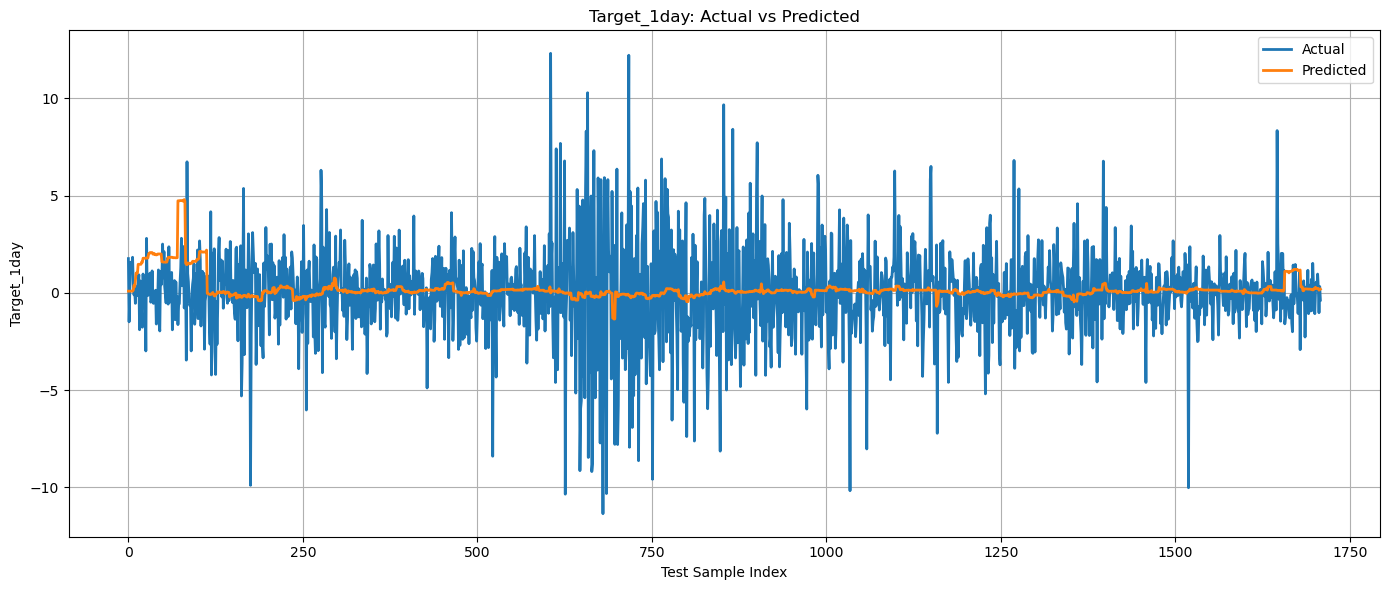

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 10, 'n_estimators': 100}

 Evaluation:
Mean Squared Error (MSE): 20.3776
Mean Absolute Error (MAE): 3.4703
R² Score: 0.0798


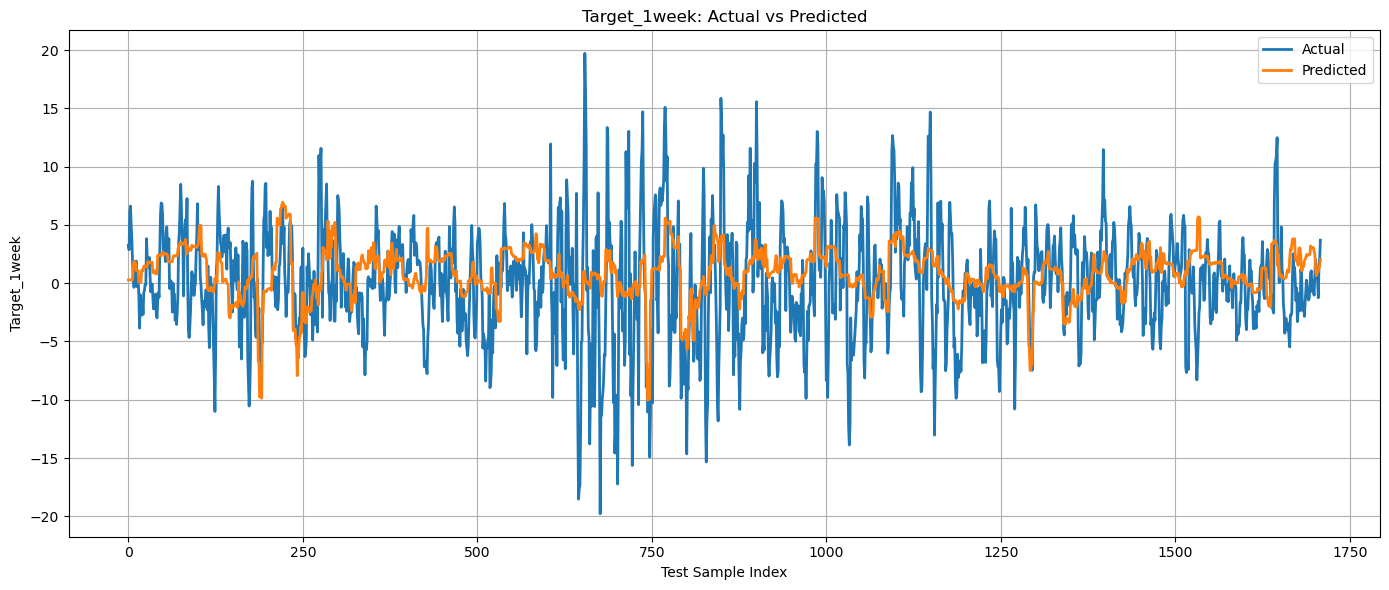

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 20, 'n_estimators': 100}

 Evaluation:
Mean Squared Error (MSE): 62.5847
Mean Absolute Error (MAE): 5.9927
R² Score: 0.1323


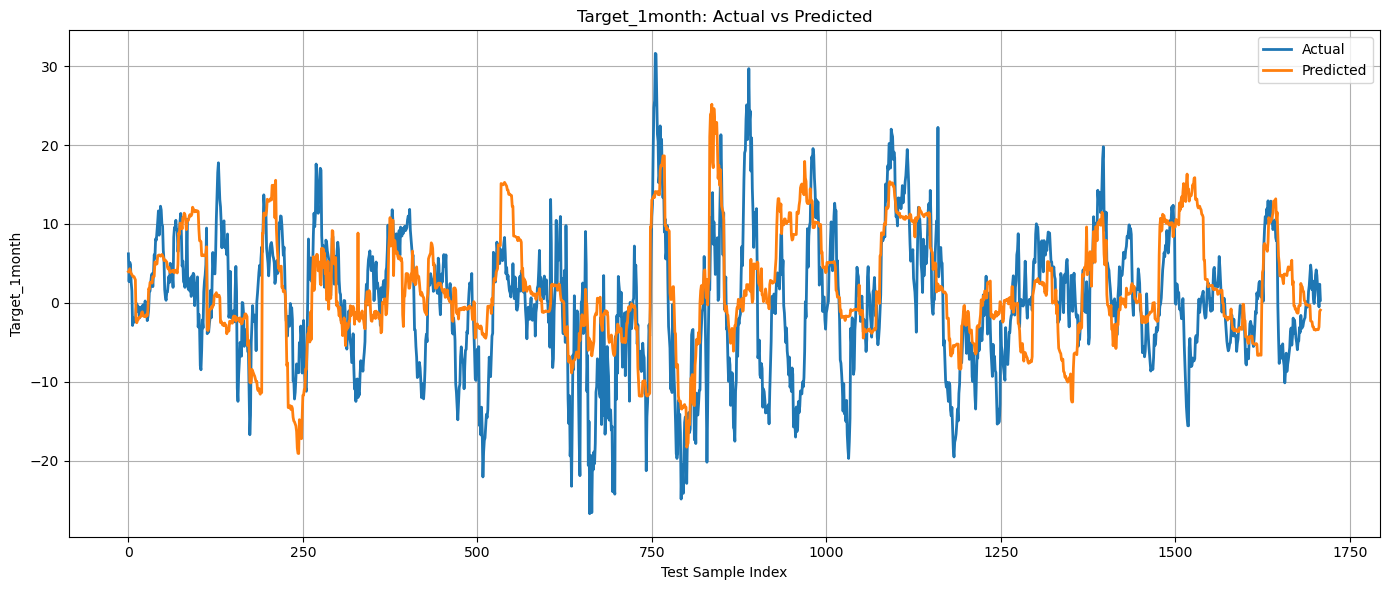

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 20, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 839.4943
Mean Absolute Error (MAE): 24.4628
R² Score: -0.0924


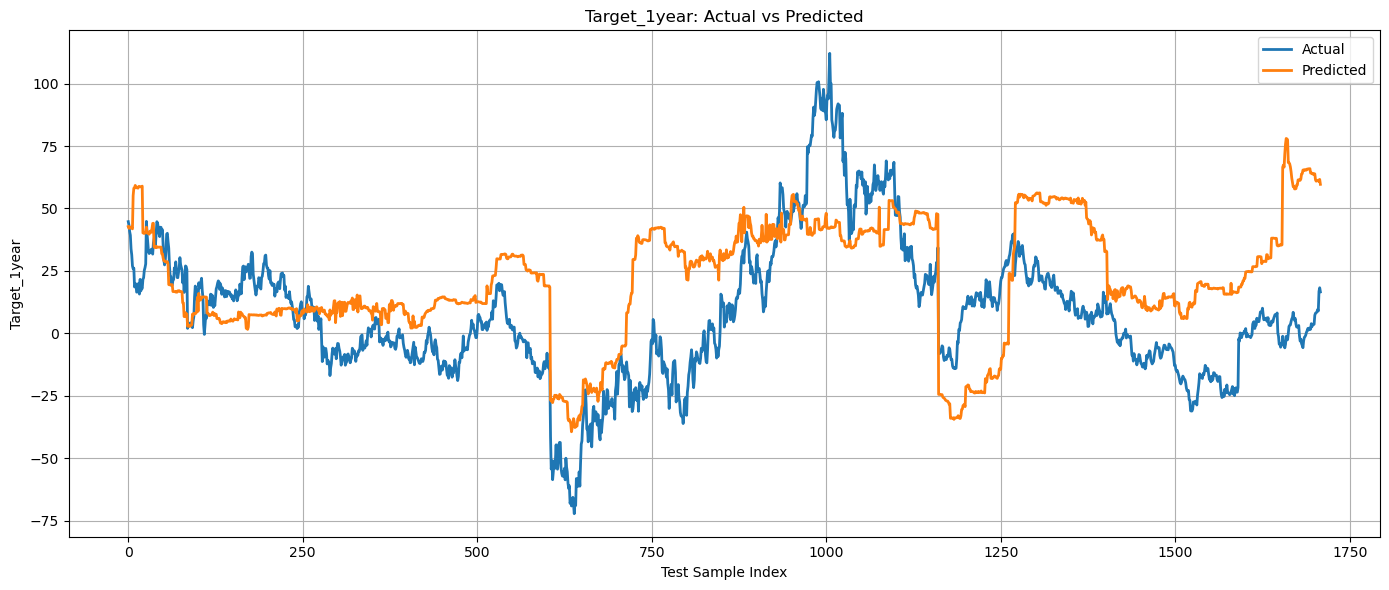

In [7]:
random_forest(df_pca, 'Target_1day')
random_forest(df_pca, 'Target_1week')
random_forest(df_pca, 'Target_1month')
random_forest(df_pca, 'Target_1year')

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

def lightgbm_model(data, target):
    df = data.copy()
    
    # 1. 타겟 처리
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # 2. 날짜 처리
    df['Date'] = pd.to_datetime(df['Date'])

    # 3. 범주형 처리
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # 4. X, y 분리
    y = df[target]
    X = df.drop(columns=['Date', target])

    # 5. 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 6. 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # 7. 하이퍼파라미터 그리드
    param_grid = {
        'num_leaves': [31, 63],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200]
    }

    # 8. GridSearchCV
    model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               verbose=0,
                               n_jobs=-1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # 9. 예측
    y_pred = best_model.predict(X_test)

    # 10. 평가
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # 11. 시각화
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted (LightGBM)')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41135
[LightGBM] [Info] Number of data points in the train set: 4557, number of used features: 345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41525
[LightGBM] [Info] Number of data points in the train set: 4558, number of used features: 344
[LightGBM] [Info] Start training from score 0.064196
[LightGBM] [Info] Start training from score 0.055627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41453
[LightGBM] [Info] Number of data points in the train 

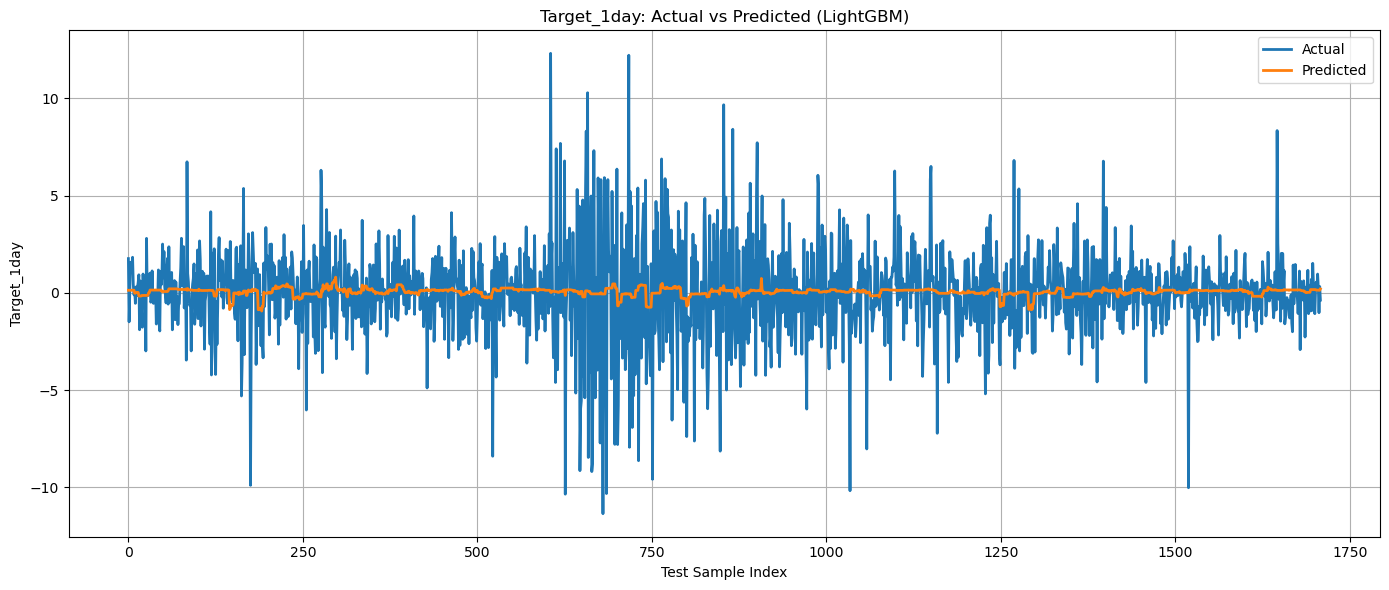

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41453
[LightGBM] [Info] Number of data points in the train set: 4557, number of used features: 344
[LightGBM] [Info] Start training from score 0.332956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41135
[LightGBM] [Info] Number of data points in the train set: 4557, number of used features: 345
[LightGBM] [Info] Start training from score 0.314656
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

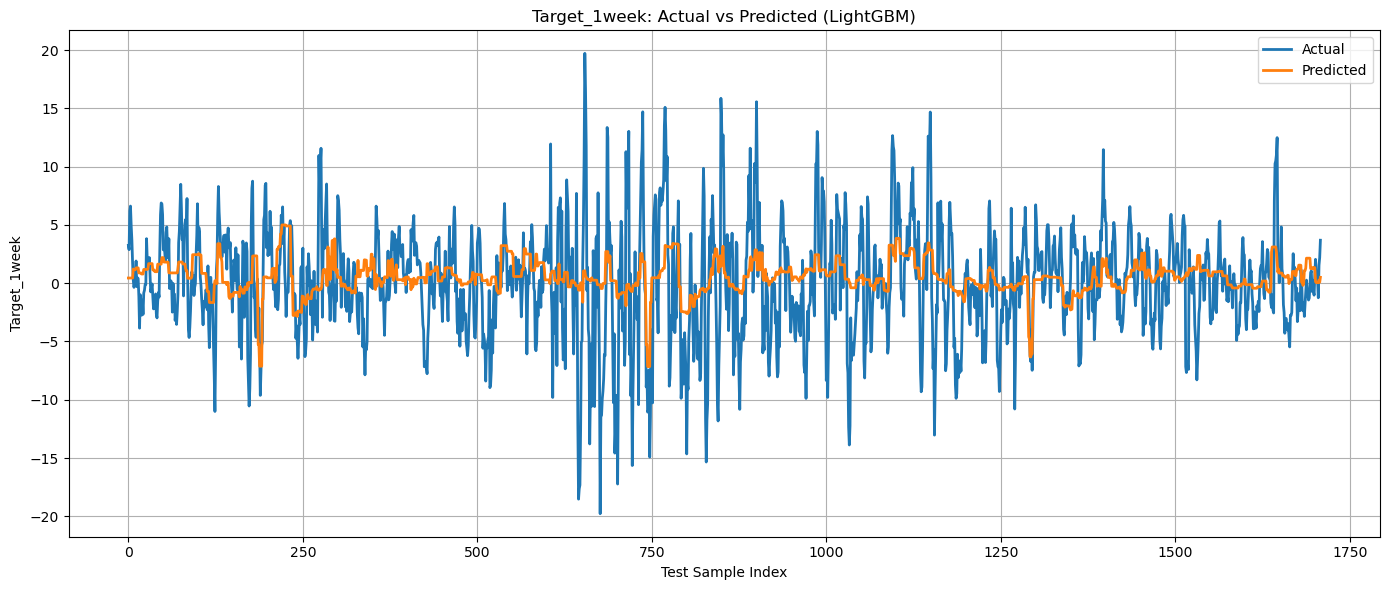

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41525
[LightGBM] [Info] Number of data points in the train set: 4558, number of used features: 344
[LightGBM] [Info] Start training from score 1.022886
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41135
[LightGBM] [Info] Number of data points in the train set: 4557, number of used features: 345
[LightGBM] [Info] Start training from score 1.227194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

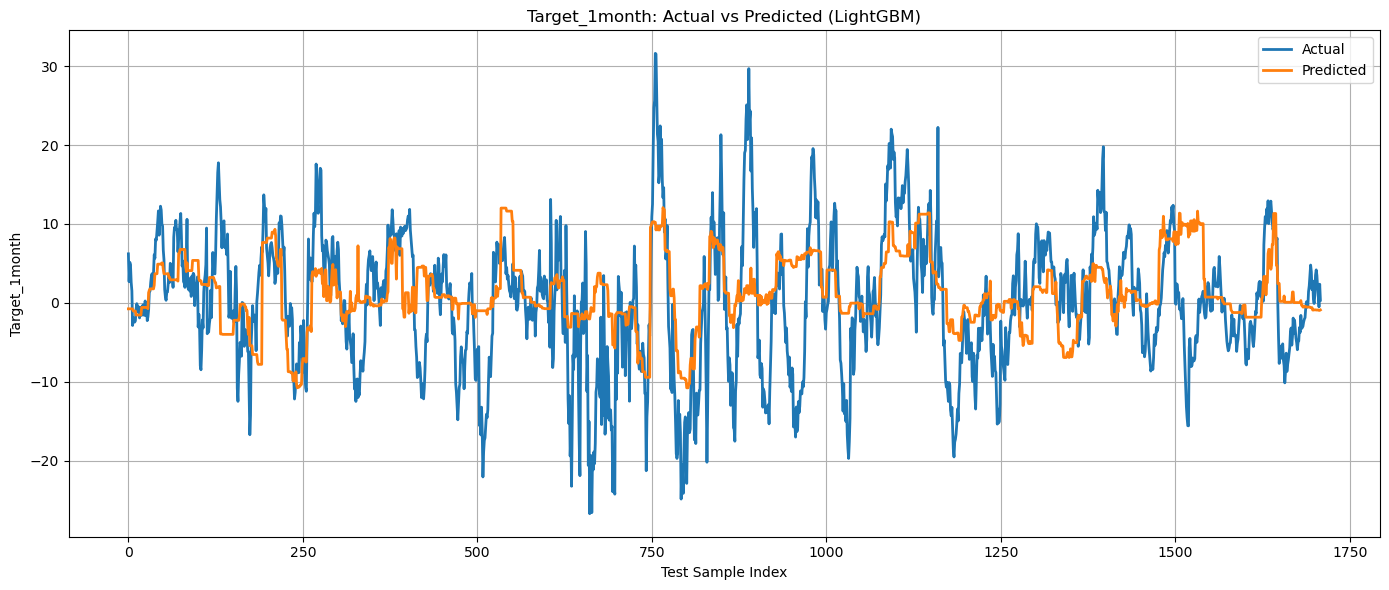

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41453
[LightGBM] [Info] Number of data points in the train set: 4557, number of used features: 344
[LightGBM] [Info] Start training from score 26.561894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41525
[LightGBM] [Info] Number of data points in the train set: 4558, number of used features: 344
[LightGBM] [Info] Start training from score 23.307914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

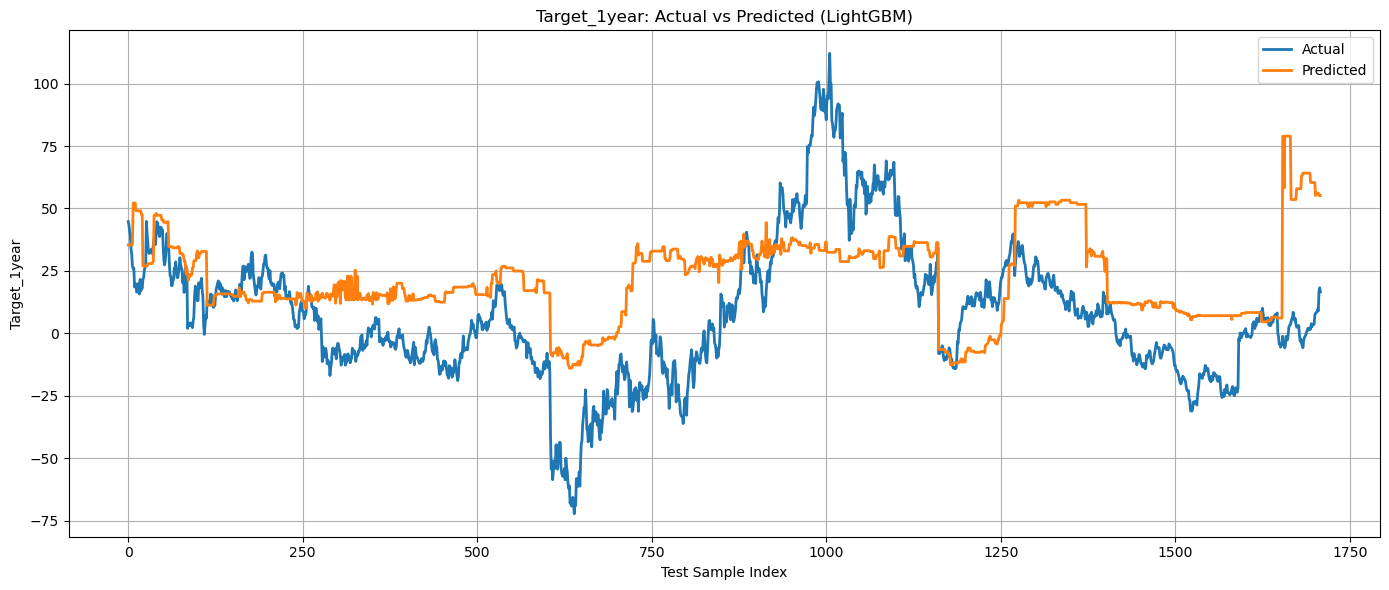

In [9]:
lightgbm_model(df_pca, 'Target_1day')
lightgbm_model(df_pca, 'Target_1week')
lightgbm_model(df_pca, 'Target_1month')
lightgbm_model(df_pca, 'Target_1year')